In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



In [5]:
# Load the data
print("Loading McDonald's customer data...")
df = pd.read_csv('mcdonalds.csv')
print(f"We have {len(df)} customers with {len(df.columns)} features")
print("\nFirst 3 customers:")
print(df.head(3))

Loading McDonald's customer data...
We have 1453 customers with 15 features

First 3 customers:
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [6]:
# Step 1: Clean the data (make it ready for machine learning)
print("\n--- Step 1: Cleaning the data ---")

# Make a copy to work with
data = df.copy()


--- Step 1: Cleaning the data ---


In [10]:
# Fix the 'Like' column (some values are text like "I love it!+5")
def fix_like_score(value):
    if 'love it' in str(value):
        return 5
    elif 'hate it' in str(value):
        return -5
    elif '+' in str(value):
        return int(str(value).replace('+', ''))
    else:
        return int(value)

data['Like'] = data['Like'].apply(fix_like_score)
print("Fixed Like scores to numbers")

Fixed Like scores to numbers


In [11]:
# Convert Yes/No answers to 1/0
yes_no_columns = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy',
                  'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting']

for col in yes_no_columns:
    data[col] = (data[col] == 'Yes').astype(int)
print("Changed Yes/No to 1/0")

Changed Yes/No to 1/0


In [12]:
# Convert visit frequency to numbers
visit_mapping = {
    'Never': 0,
    'Once a year': 1,
    'Every three months': 2,
    'Once a month': 3,
    'Once a week': 4,
    'More than once a week': 5
}
data['VisitFrequency'] = data['VisitFrequency'].map(visit_mapping)
print("Changed visit frequency to numbers")

Changed visit frequency to numbers


In [13]:
# Convert gender to numbers
data['Gender'] = (data['Gender'] == 'Male').astype(int)
print("Changed gender to numbers (Male=1, Female=0)")

print("\nData is now clean and ready!")

Changed gender to numbers (Male=1, Female=0)

Data is now clean and ready!


In [14]:
# Step 2: Prepare features for machine learning
print("\n--- Step 2: Preparing features ---")

# Use all the numeric columns
features = data.select_dtypes(include=[np.number]).columns.tolist()
X = data[features]
print(f"Using {len(features)} features: {features}")

# Scale the features (make them all similar size)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled all features to similar ranges")


--- Step 2: Preparing features ---
Using 15 features: ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age', 'VisitFrequency', 'Gender']
Scaled all features to similar ranges


In [15]:
# Step 3: Reduce dimensions with PCA (simplify the data)
print("\n--- Step 3: Using PCA to simplify data ---")

# Try PCA with different numbers of components
pca = PCA(n_components=0.95)  # Keep 95% of information
X_pca = pca.fit_transform(X_scaled)

print(f"Reduced from {X.shape[1]} features to {X_pca.shape[1]} components")
print(f"Kept {pca.explained_variance_ratio_.sum():.1%} of the original information")



--- Step 3: Using PCA to simplify data ---
Reduced from 15 features to 13 components
Kept 96.8% of the original information


In [16]:
# Step 4: Find the best number of customer groups
print("\n--- Step 4: Finding best number of groups ---")

# Try different numbers of groups (2 to 8)
possible_groups = range(2, 9)
scores = []

for k in possible_groups:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    scores.append(score)
    print(f"{k} groups: score = {score:.3f}")

# Pick the number with highest score
best_k = possible_groups[np.argmax(scores)]
best_score = max(scores)
print(f"\nBest number of groups: {best_k} (score: {best_score:.3f})")


--- Step 4: Finding best number of groups ---
2 groups: score = 0.204
3 groups: score = 0.154
4 groups: score = 0.161
5 groups: score = 0.152
6 groups: score = 0.166
7 groups: score = 0.165
8 groups: score = 0.167

Best number of groups: 2 (score: 0.204)


In [17]:
# Step 5: Create the final customer groups
print("\n--- Step 5: Creating customer groups ---")

final_kmeans = KMeans(n_clusters=best_k, random_state=42)
customer_groups = final_kmeans.fit_predict(X_pca)

# Add group labels to our data
data['CustomerGroup'] = customer_groups

print("Customer groups created!")
print("Group sizes:")
for group in range(best_k):
    count = sum(customer_groups == group)
    percent = count / len(data) * 100
    print(f"Group {group}: {count} customers ({percent:.1f}%)")


--- Step 5: Creating customer groups ---
Customer groups created!
Group sizes:
Group 0: 547 customers (37.6%)
Group 1: 906 customers (62.4%)


In [19]:
# Step 6: Understand what each group is like
print("\n--- Step 6: Understanding each customer group ---")

for group in range(best_k):
    print(f"\n=== GROUP {group} ===")
    group_data = data[data['CustomerGroup'] == group]

    # Basic info
    print(f"Size: {len(group_data)} customers")
    print(f"Average age: {group_data['Age'].mean():.1f} years")
    print(f"Average like score: {group_data['Like'].mean():.1f}")
    print(f"Percent male: {group_data['Gender'].mean()*100:.0f}%")




--- Step 6: Understanding each customer group ---

=== GROUP 0 ===
Size: 547 customers
Average age: 49.3 years
Average like score: -2.3
Percent male: 48%

=== GROUP 1 ===
Size: 906 customers
Average age: 41.8 years
Average like score: 2.6
Percent male: 44%


In [23]:
# Visit frequency
avg_visit = group_data['VisitFrequency'].mean()
visit_labels = {0: 'Never', 1: 'Once a year', 2: 'Every 3 months',3: 'Once a month', 4: 'Once a week', 5: 'More than once a week'}
print(f"Visit frequency: {visit_labels[round(avg_visit)]}")

Visit frequency: Once a month


In [25]:
# What they think about McDonald's
print("What they think McDonald's is:")
opinions = {}
for col in yes_no_columns:
  opinions[col] = group_data[col].mean()

# Show top 3 things they agree with
top_opinions = sorted(opinions.items(), key=lambda x: x[1], reverse=True)[:3]
print(f"Top opinions: {', '.join([f'{op} ({score:.2f})' for op, score in top_opinions])}")

What they think McDonald's is:
Top opinions: convenient (0.98), fast (0.94), tasty (0.93)



--- Step 7: Creating charts ---


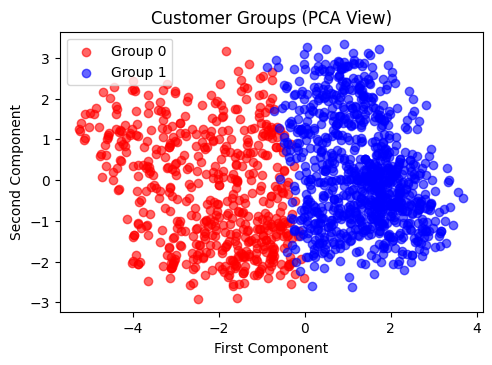

In [26]:
# Step 7: Create simple visualizations
print("\n--- Step 7: Creating charts ---")

# Chart 1: Show groups in PCA space
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
for group in range(best_k):
    group_points = X_pca[customer_groups == group]
    plt.scatter(group_points[:, 0], group_points[:, 1],
               c=colors[group], label=f'Group {group}', alpha=0.6)
plt.title('Customer Groups (PCA View)')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.legend()

<ipython-input-27-2e8f7770c3c6>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ages_by_group, labels=[f'Group {i}' for i in range(best_k)])


Text(0, 0.5, 'Age')

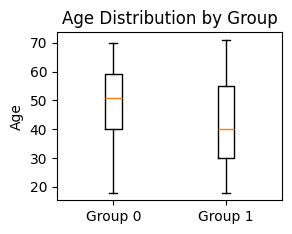

In [27]:
# Chart 2: Age by group
plt.subplot(2, 2, 2)
ages_by_group = [data[data['CustomerGroup'] == group]['Age'] for group in range(best_k)]
plt.boxplot(ages_by_group, labels=[f'Group {i}' for i in range(best_k)])
plt.title('Age Distribution by Group')
plt.ylabel('Age')

<ipython-input-28-8fe39fa3714a>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(like_by_group, labels=[f'Group {i}' for i in range(best_k)])


Text(0, 0.5, 'Like Score')

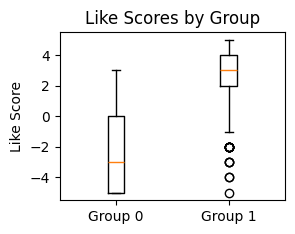

In [28]:
# Chart 3: Like scores by group
plt.subplot(2, 2, 3)
like_by_group = [data[data['CustomerGroup'] == group]['Like'] for group in range(best_k)]
plt.boxplot(like_by_group, labels=[f'Group {i}' for i in range(best_k)])
plt.title('Like Scores by Group')
plt.ylabel('Like Score')

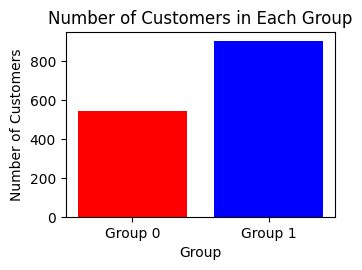

In [29]:
# Chart 4: Group sizes
plt.subplot(2, 2, 4)
group_sizes = [sum(customer_groups == group) for group in range(best_k)]
plt.bar(range(best_k), group_sizes, color=colors[:best_k])
plt.title('Number of Customers in Each Group')
plt.xlabel('Group')
plt.ylabel('Number of Customers')
plt.xticks(range(best_k), [f'Group {i}' for i in range(best_k)])

plt.tight_layout()
plt.show()


In [30]:
# Summary
print("\n" + "="*50)
print("SUMMARY - What we learned:")
print("="*50)
print(f"✓ We grouped {len(data)} McDonald's customers into {best_k} different types")
print(f"✓ Our grouping quality score: {best_score:.3f} (higher is better)")
print(f"✓ We used {len(features)} customer features to make the groups")
print(f"✓ PCA helped us simplify the data while keeping {pca.explained_variance_ratio_.sum():.1%} of information")

print("\nEach group represents customers with similar:")
print("- Age and gender")
print("- How much they like McDonald's")
print("- How often they visit")
print("- What they think about the food (tasty, healthy, etc.)")

print("\nThis can help McDonald's:")
print("- Create different marketing for each group")
print("- Understand what different customers want")
print("- Improve products based on customer opinions")


SUMMARY - What we learned:
✓ We grouped 1453 McDonald's customers into 2 different types
✓ Our grouping quality score: 0.204 (higher is better)
✓ We used 15 customer features to make the groups
✓ PCA helped us simplify the data while keeping 96.8% of information

Each group represents customers with similar:
- Age and gender
- How much they like McDonald's
- How often they visit
- What they think about the food (tasty, healthy, etc.)

This can help McDonald's:
- Create different marketing for each group
- Understand what different customers want
- Improve products based on customer opinions
